In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from tqdm import tqdm_notebook as tqdm

In [35]:
def point_setup(img_list):
    obj_points = []
    img_points = []
    for image in tqdm(img_list):
        img = cv2.imread(image)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            img_points.append(corners)
            obj_points.append(obj_ideal)
    return obj_points, img_points

def camera_cal(input_img, objpoints, imgpoints):
    img = mpimg.imread(input_img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    fix_img = cv2.undistort(img, mtx, dist, None, mtx)
    return gray, fix_img

def camera_cal_img_feed(input_img, objpoints, imgpoints):
    gray = cv2.cvtColor(input_img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    fix_img = cv2.undistort(input_img, mtx, dist, None, mtx)
    return gray, fix_img


#Gradient and Thresholding Corrected Image - Only really needed for curvature detection
def threshold_trans(raw_img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(raw_img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(raw_img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

def perspective_trans_trainer(undist_img):
    img_size = (undist_img.shape[1], undist_img.shape[0])
    draw_img = undist_img.copy()
    #Source Coordinates - (x,y) - NW, SW, SE, NE
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 97],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 45, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 97]])
  
    
    #Desired Coordinates - SE, NE, NW, SE
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    #Generate perspective transform
    M = cv2.getPerspectiveTransform(src,dst)

    #Inverse transform
    M_inv = cv2.getPerspectiveTransform(dst,src)
    
    pts = src.reshape((-1,1,2))
    drawn_img = cv2.polylines(draw_img,np.int32([src]),True,(0,255,0),1)

    #Transform Image
    flattened = cv2.warpPerspective(draw_img, M, img_size, flags=cv2.INTER_LINEAR)
    
    drawn_img = cv2.polylines(draw_img,np.int32([src]),True,(255,0,0),15)
      
    return drawn_img, flattened, M, M_inv


def perspective_trans(undist_img, M):
    img_size = (undist_img.shape[1], undist_img.shape[0])
    #Transform Image
    flattened = cv2.warpPerspective(undist_img, M, img_size, flags=cv2.INTER_LINEAR)
    return flattened


#Vertical Sliding Window Search for Lane Lines
def lane_line_search_initial(binary_warped, nwindows):
    #print(binary_warped.shape)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
   
    return out_img, left_fitx, right_fitx, ploty , left_fit, right_fit

def lane_line_search_cont(binary_warped, margin, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fitx, right_fitx, ploty 


#Caclulate Radius of curvature for both lanes - expects input points from top to bottom, sorted using the y-axis
def radii_calc(leftx, rightx, ploty):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

#Highway should never be lower than 180 m, should be seeing something in the 450 m to 850 m range

def recast_img(warped, left_fitx, right_fitx, ploty, undistorted_image, M_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int32([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    return result


## Camera Calibration
<b>Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.</b>

Much of this project leaned heavily on the classroom material. I loaded a calibration image, modified the code to acccept a 9x6 chessboard, instead of an 8x6, and proceeded from there.

In the following cell, I copied two functions from the massive second cell, which contains all the functions used in this project.

For camera calibration, I used `point_setup()` to find the corners of teh chessboard, and output those corners. Next, `camera_cal()` takes in the compiled list of 3D and 2D points, and calibrates the image using OpenCV's calibrateCamera function.


In [ ]:
def point_setup(img_list):
    obj_points = []
    img_points = []
    for image in tqdm(img_list):
        img = cv2.imread(image)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            img_points.append(corners)
            obj_points.append(obj_ideal)
    return obj_points, img_points

def camera_cal(input_img, objpoints, imgpoints):
    img = mpimg.imread(input_img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    fix_img = cv2.undistort(img, mtx, dist, None, mtx)
    return gray, fix_img

20


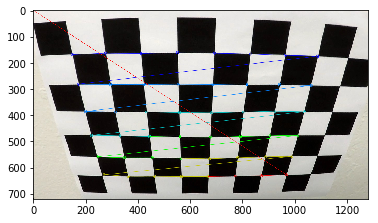

'\n#Perspective Test\nplt.imshow("lane_image")\nplt.plot(500, 500, \'*\') #point 1\nplt.plot(500, 500, \'*\') #point 1\nplt.plot(500, 500, \'*\') #point 1\nplt.plot(500, 500, \'*\') #point 1\n'

In [15]:
#Camera Calibration Test Cell

cal_img = glob.glob("camera_cal/*")

print(len(cal_img))

im_test = mpimg.imread(cal_img[0])

#plt.imshow(im_test)


obj_points = []
img_points = []


obj_ideal = np.zeros((6*9,3),np.float32)
obj_ideal[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

gray = cv2.cvtColor(im_test,cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
if ret == True:
    img_points.append(corners)
    obj_points.append(obj_ideal)
    
    img = cv2.drawChessboardCorners(im_test,(9,6),corners, ret)
    plt.imshow(img)

plt.show()

In [3]:
from sklearn.externals import joblib

#Camera Calibration Cell
cal_img = glob.glob("camera_cal/*")

full_obj_points = []

full_img_points = []

obj_ideal = np.zeros((6*9,3),np.float32)
obj_ideal[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

obj_points_tmp, img_points_tmp = point_setup(cal_img)

full_obj_points.extend(obj_points_tmp)
joblib.dump(full_obj_points, 'obj_pts.pkl') 


full_img_points.extend(img_points_tmp)
joblib.dump(full_img_points, 'img_pts.pkl')


['img_pts.pkl']

### Camera Calibration Visualization

Here I plot the original, the "grey" image fed into the calibration function, and then the output image, which should correct for camera distortion. It appears to have worked! The lines in the 'Fixed' image are nice and straight.

camera_cal/calibration2.jpg
Done


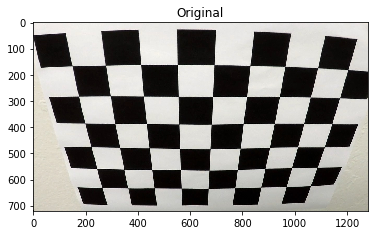

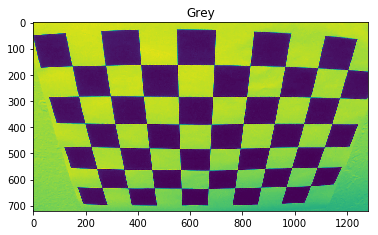

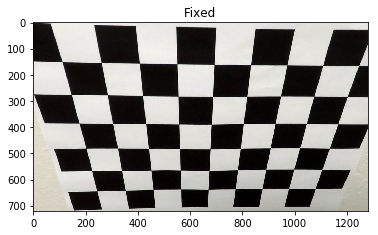

In [68]:
input_img = cal_img[0]

print(input_img)

gray_org, fixed_org = camera_cal(input_img, full_obj_points, full_img_points)

print("Done")

fig1 = plt.figure(1)
plt.imshow(mpimg.imread(input_img))
plt.title('Original')
fig2 = plt.figure(2)
plt.imshow(gray_org)
plt.title('Grey')
fig2 = plt.figure(3)
plt.imshow(fixed_org)
plt.title('Fixed')
plt.show()


### Testing Distortion Transforms on Images

An example of a distortion-corrected image.

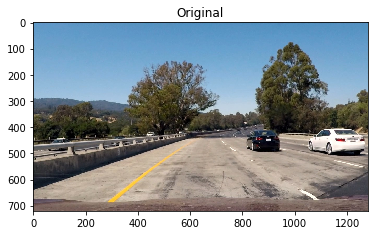

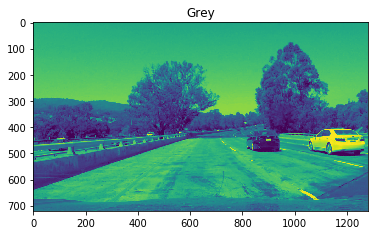

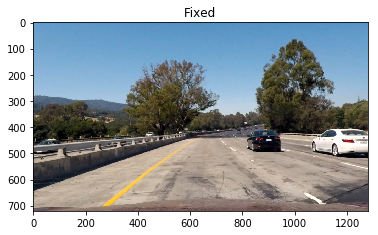

In [8]:
#Apply Distortion Transform to Test Image

input_img1 = "./test_images/test1.jpg"

gray_org1, fixed_org1 = camera_cal(input_img1, full_obj_points, full_img_points)

fig1 = plt.figure(1)
plt.imshow(mpimg.imread(input_img1))
plt.title('Original')
fig2 = plt.figure(2)
plt.imshow(gray_org1)
plt.title('Grey')
fig2 = plt.figure(3)
plt.imshow(fixed_org1)
plt.title('Fixed')
plt.show()


<b>Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.</b>

`threshold_trans()` implements the thresholding processes illustrated in the classwork. A distortion-corrected image is converted into the HLS space, and the S channel is pulled from that 3-channel image. The S-channel is thresholded to focus in features that are highly saturated, helpful for picking out luminous objects like reflective lane lines. 

In addition to the HLS conversion, the input image is also converted to grayscale and a Sobel filter is applied to find where the vertical jumps occur, indicating a high likelyhood that a line exists at that point. To cut away unecessary information, the gradient value is also thresholded.

The color_binary output shows the effects of the two different channels, and the combined_binary takes the `OR` of the two sets.

In [ ]:
#Gradient and Thresholding Corrected Image - Only really needed for curvature detection
def threshold_trans(raw_img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(raw_img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(raw_img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary


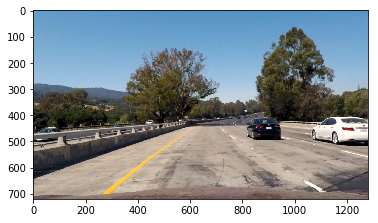

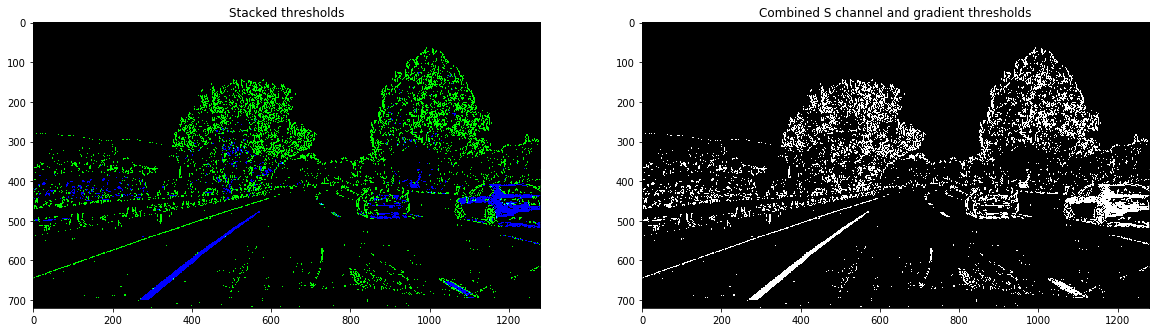

In [9]:
#Apply Threshold on Fixed Images

plt.imshow(fixed_org1)

color_binary, combined_binary = threshold_trans(fixed_org1)


# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

plt.show()


<b>Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.</b>

The perspective transform is done in two steps. First, `perspective_trans_trainer` takes in an image to develop the perspective transform matrix.

I use an image with long straight lines and no bends visible in image to make it easier to determine the source and destination coordinates. 

Once `M` has been defined, `perspective_trans()` is used to transform subsequent frames.

In [ ]:
def perspective_trans_trainer(undist_img):
    img_size = (undist_img.shape[1], undist_img.shape[0])
    draw_img = undist_img.copy()
    #Source Coordinates - (x,y) - NW, SW, SE, NE
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 97],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 45, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 97]])
  
    
    #Desired Coordinates - SE, NE, NW, SE
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    #Generate perspective transform
    M = cv2.getPerspectiveTransform(src,dst)

    #Inverse transform
    M_inv = cv2.getPerspectiveTransform(dst,src)
    
    pts = src.reshape((-1,1,2))
    drawn_img = cv2.polylines(draw_img,np.int32([src]),True,(0,255,0),1)

    #Transform Image
    flattened = cv2.warpPerspective(draw_img, M, img_size, flags=cv2.INTER_LINEAR)
    
    drawn_img = cv2.polylines(draw_img,np.int32([src]),True,(255,0,0),15)
      
    return drawn_img, flattened, M, M_inv


def perspective_trans(undist_img, M):
    img_size = (undist_img.shape[1], undist_img.shape[0])
    #Transform Image
    flattened = cv2.warpPerspective(undist_img, M, img_size, flags=cv2.INTER_LINEAR)
    return flattened


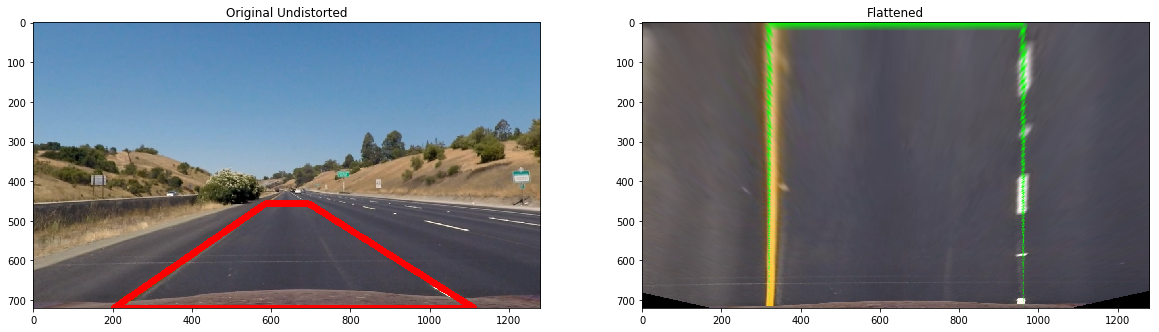

In [21]:
#Perspective Transform

input_img1 = "./test_images/straight_lines1.jpg"

gray_org2, fixed_org2 = camera_cal(input_img1, full_obj_points, full_img_points)

overlaid, pers_trans, M, M_inv = perspective_trans_trainer(fixed_org2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Undistorted')
ax1.imshow(overlaid)

ax2.set_title('Flattened')
ax2.imshow(pers_trans)

plt.show()


<b>Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?</b>

Input image > perspective transform > gradient threshold > histogram with sliding window search > polyfit on "hot" pixels

In [ ]:
#Vertical Sliding Window Search for Lane Lines
def lane_line_search_initial(binary_warped, nwindows):
    #print(binary_warped.shape)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
   
    return out_img, left_fitx, right_fitx, ploty , left_fit, right_fit

def lane_line_search_cont(binary_warped, margin, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fitx, right_fitx, ploty 


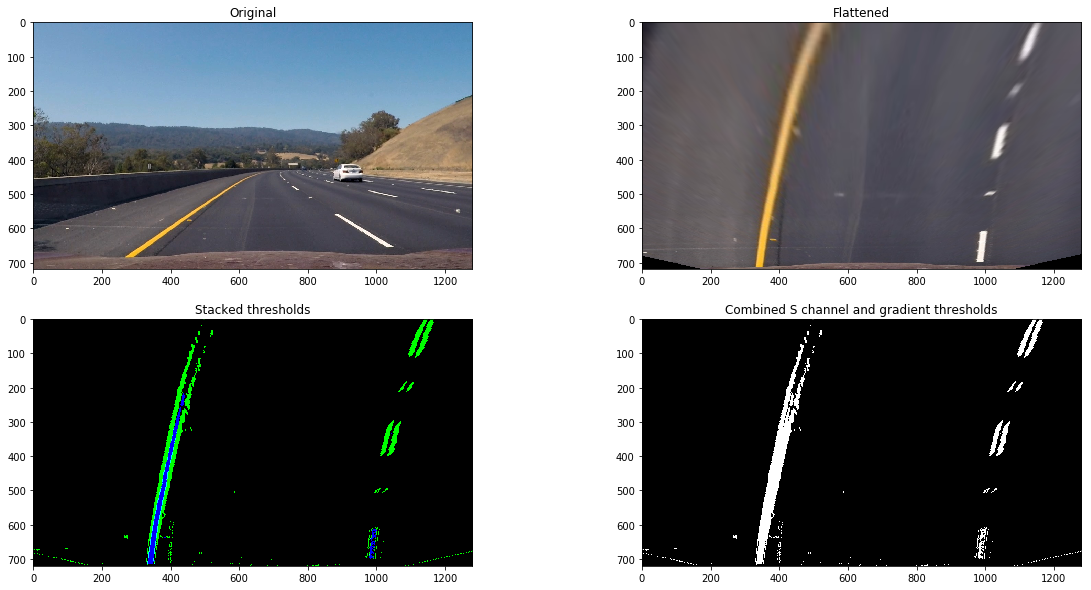

In [11]:
#Curved Lane Line Findig

input_img2 = "./test_images/test3.jpg"

gray_org3, fixed_org3 = camera_cal(input_img2, full_obj_points, full_img_points)

flattened_curve = perspective_trans(fixed_org3, M)

color_binary1, combined_binary1 = threshold_trans(flattened_curve)

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(mpimg.imread(input_img2))

ax2.set_title('Flattened')
ax2.imshow(flattened_curve)

ax3.set_title('Stacked thresholds')
ax3.imshow(color_binary1)

ax4.set_title('Combined S channel and gradient thresholds')
ax4.imshow(combined_binary1, cmap='gray')

plt.show()


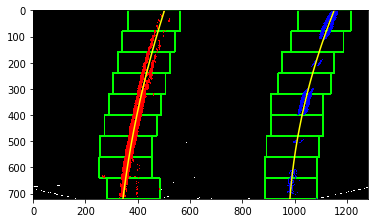

In [12]:
#Curved Lane Line Sliding Window Search


out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = lane_line_search_initial(combined_binary1, 9)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.show()

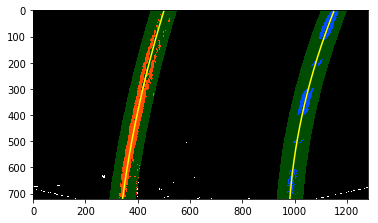

In [13]:
#Curved Lane Line Continuing Search

result, left_fitx1, right_fitx1, ploty1 = lane_line_search_cont(combined_binary1, 50, left_fit, right_fit)

plt.imshow(result)
plt.plot(left_fitx1, ploty1, color='yellow')
plt.plot(right_fitx1, ploty1, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.show()

<b>Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.</b>

Using the radii equatione, use polyfit to fit left and right lines, and then plug the values into the given equation to solve for the radius.

In [ ]:
#Caclulate Radius of curvature for both lanes - expects input points from top to bottom, sorted using the y-axis
def radii_calc(leftx, rightx, ploty):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

In [14]:
#Radius Of Curvature Calculation
#Highway should never be lower than 180 m, should be seeing something in the 450 m to 850 m range

leftcr, rightcr = radii_calc(left_fitx, right_fitx, ploty)

print("Left Curve Radius: " + str(leftcr) + " meters")
print("Right Curve Radius: " + str(rightcr) + " meters")


Left Curve Radius: 1211.6880945031862 meters
Right Curve Radius: 736.2105702151039 meters


<b>Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.</b>

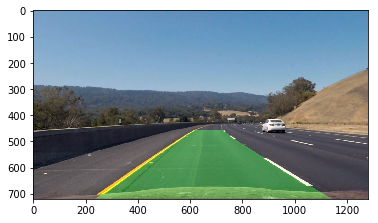

In [15]:
#Recast the lines back onto the original image and fill in the lane
out_img2, left_fitx2, right_fitx2, ploty2, left_fit2, right_fit2 = lane_line_search_initial(combined_binary1, 9)

plt.imshow(recast_img(combined_binary1, left_fitx2, right_fitx2, ploty2, fixed_org3, M_inv))
plt.show()

All Loaded


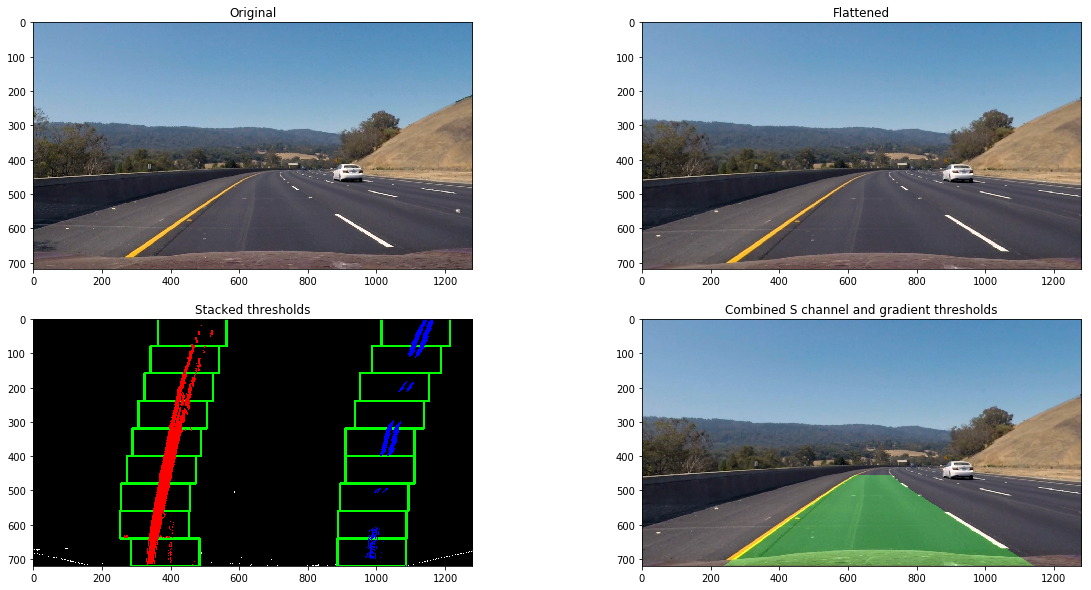

In [36]:
input_img = "./test_images/test3.jpg"

obj_pts_loaded = joblib.load('obj_pts.pkl') 
img_pts_loaded = joblib.load('img_pts.pkl') 
print("All Loaded")

def pipeline_initialization(input_image, full_obj_points, full_img_points):
    gray_org, fixed_org = camera_cal(input_image, full_obj_points, full_img_points)
    overlaid, pers_trans, M, M_inv = perspective_trans_trainer(fixed_org)
    return M, M_inv

def lane_pipeline(input_image, full_obj_points, full_img_points, M, M_inv):
    gray_org, fixed_org = camera_cal_img_feed(input_image, full_obj_points, full_img_points)
    flattened_curve = perspective_trans(fixed_org, M)
    color_binary, combined_binary = threshold_trans(flattened_curve)
    out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = lane_line_search_initial(combined_binary, 9)
    leftcr, rightcr = radii_calc(left_fitx, right_fitx, ploty)
    highlighted_frame = recast_img(combined_binary, left_fitx, right_fitx, ploty, fixed_org, M_inv)
    return fixed_org, out_img, highlighted_frame

M, M_inv = pipeline_initialization(input_img, obj_pts_loaded, img_pts_loaded)

input_img1 = mpimg.imread(input_img)

undistorted_img, lane_search, lane_detected = lane_pipeline(input_img1, obj_pts_loaded, img_pts_loaded, M, M_inv)

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(input_img1)

ax2.set_title('Flattened')
ax2.imshow(undistorted_img)

ax3.set_title('Stacked thresholds')
ax3.imshow(lane_search)

ax4.set_title('Combined S channel and gradient thresholds')
ax4.imshow(lane_detected)

plt.show()


50.4


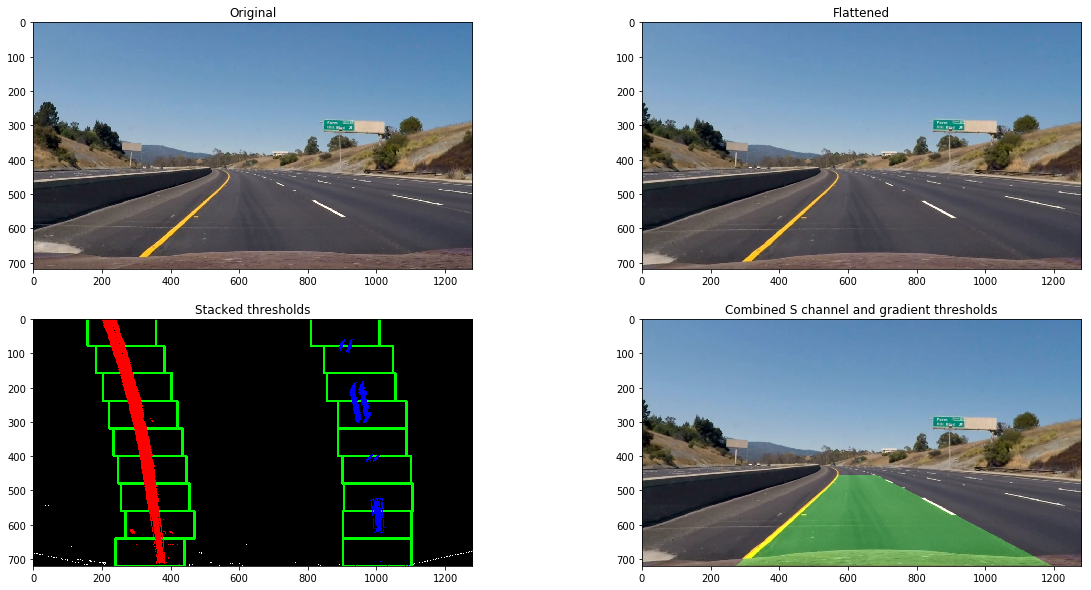

In [37]:
#Open the input video and pull out a frame
from moviepy.editor import VideoFileClip

my_clip = VideoFileClip('project_video.mp4')
print(my_clip.duration)

test_image1 = my_clip.get_frame(1)

undistorted_img, lane_search, lane_detected = lane_pipeline(test_image1, obj_pts_loaded, img_pts_loaded, M, M_inv)

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(test_image1)

ax2.set_title('Flattened')
ax2.imshow(undistorted_img)

ax3.set_title('Stacked thresholds')
ax3.imshow(lane_search)

ax4.set_title('Combined S channel and gradient thresholds')
ax4.imshow(lane_detected)

plt.show()

### Gnerating the Output Video

Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Dropbox Link - https://www.dropbox.com/s/0jg7snkemt3s8qk/ProjectVideo_LaneDetect.mp4?dl=0

In [45]:
import math
from moviepy.editor import VideoFileClip

def lane_clip_detector(clip_source, folder_loc1, fps=30):
    clip = VideoFileClip(clip_source)
    frame_count = math.floor(clip.duration*fps)+1
    for fc in tqdm(range(0, frame_count)):
        t = float(fc/fps)
        cur_frame = clip.get_frame(t)
        undistorted_img, lane_search, lane_detected = lane_pipeline(cur_frame, obj_pts_loaded, img_pts_loaded, M, M_inv)
        fix_output = cv2.cvtColor(lane_detected, cv2.COLOR_BGR2RGB)
        cv2.imwrite(folder_loc1 + str(fc) + ".png", fix_output)

lane_clip_detector("challenge_video.mp4", './Challenge_Lane_Detection/', fps=10)

### Discusssion

<b>Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?</b>

Doesn't work well in shadow or faint lines. Change in surface from asphalt to concrete degrades performance. Shadow is an issue, especially since the S channel is the key colorspace. Variations in the road surface do to patches, cracks, or other imperfections will also affect the fill as evidenced in the challenge video stills.